# Classification

We are now looking to predict the response variable y as a function of x inputs where y is now categorical.

Necessary packages:
1. MASS (if in anaconda package manager, search 'r-mass')
2. glmnet (if in anaconda package manager, search 'r-glmnet')
3. Matrix (if in anaconda package manager, search 'r-matrix')

Necessar R-Scricpt Files (these are accessed through source)
1. naref_no_gamlr.R (allows for changing of factor columns in dataframes to base level NA such that a model motrix can be made with indicators for all factor levels)
2. roc.R (allows for plotting the Receiver Operator Curve)

In [1]:
#Set the working directory to the specific location of the files on your computer
#note: In this case, the working directory was set for my computer
setwd("/Users/Brandon/Harding_ML_Class")

## K-Nearest Neighbors Algorithm (K-NN)

This algorithm seeks to classify an item based on its euclidean distance using inputs variables to the nearest classified items. We will use the forensic glass dataset found in R to demonstrate how this algorithm works. We will attempt to predict the type of glass based on a glass's refractive index (RI) and chemical composition.

In [2]:
#Load library of example datasets
library("MASS")

#Loads the data into R; see help(fgl)
data("fgl")

In [3]:
#View structure of the dataset
str(fgl)

#View levels of the response variable type
levels(fgl$type)

'data.frame':	214 obs. of  10 variables:
 $ RI  : num  3.01 -0.39 -1.82 -0.34 -0.58 ...
 $ Na  : num  13.6 13.9 13.5 13.2 13.3 ...
 $ Mg  : num  4.49 3.6 3.55 3.69 3.62 3.61 3.6 3.61 3.58 3.6 ...
 $ Al  : num  1.1 1.36 1.54 1.29 1.24 1.62 1.14 1.05 1.37 1.36 ...
 $ Si  : num  71.8 72.7 73 72.6 73.1 ...
 $ K   : num  0.06 0.48 0.39 0.57 0.55 0.64 0.58 0.57 0.56 0.57 ...
 $ Ca  : num  8.75 7.83 7.78 8.22 8.07 8.07 8.17 8.24 8.3 8.4 ...
 $ Ba  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fe  : num  0 0 0 0 0 0.26 0 0 0 0.11 ...
 $ type: Factor w/ 6 levels "WinF","WinNF",..: 1 1 1 1 1 1 1 1 1 1 ...


[1] "WinF"  "WinNF" "Veh"   "Con"   "Tabl"  "Head"

### Since our goal is to determine a glass type (the response variable), lets construct a few boxplots to determine if any variable is a clear discriminator of glass type (aka the variables presence clearly indicates one type of class for the response variable).

### You will see that in the BA plot (lower left), rthe presence of this chemical is a clear signal that the glass is of type head

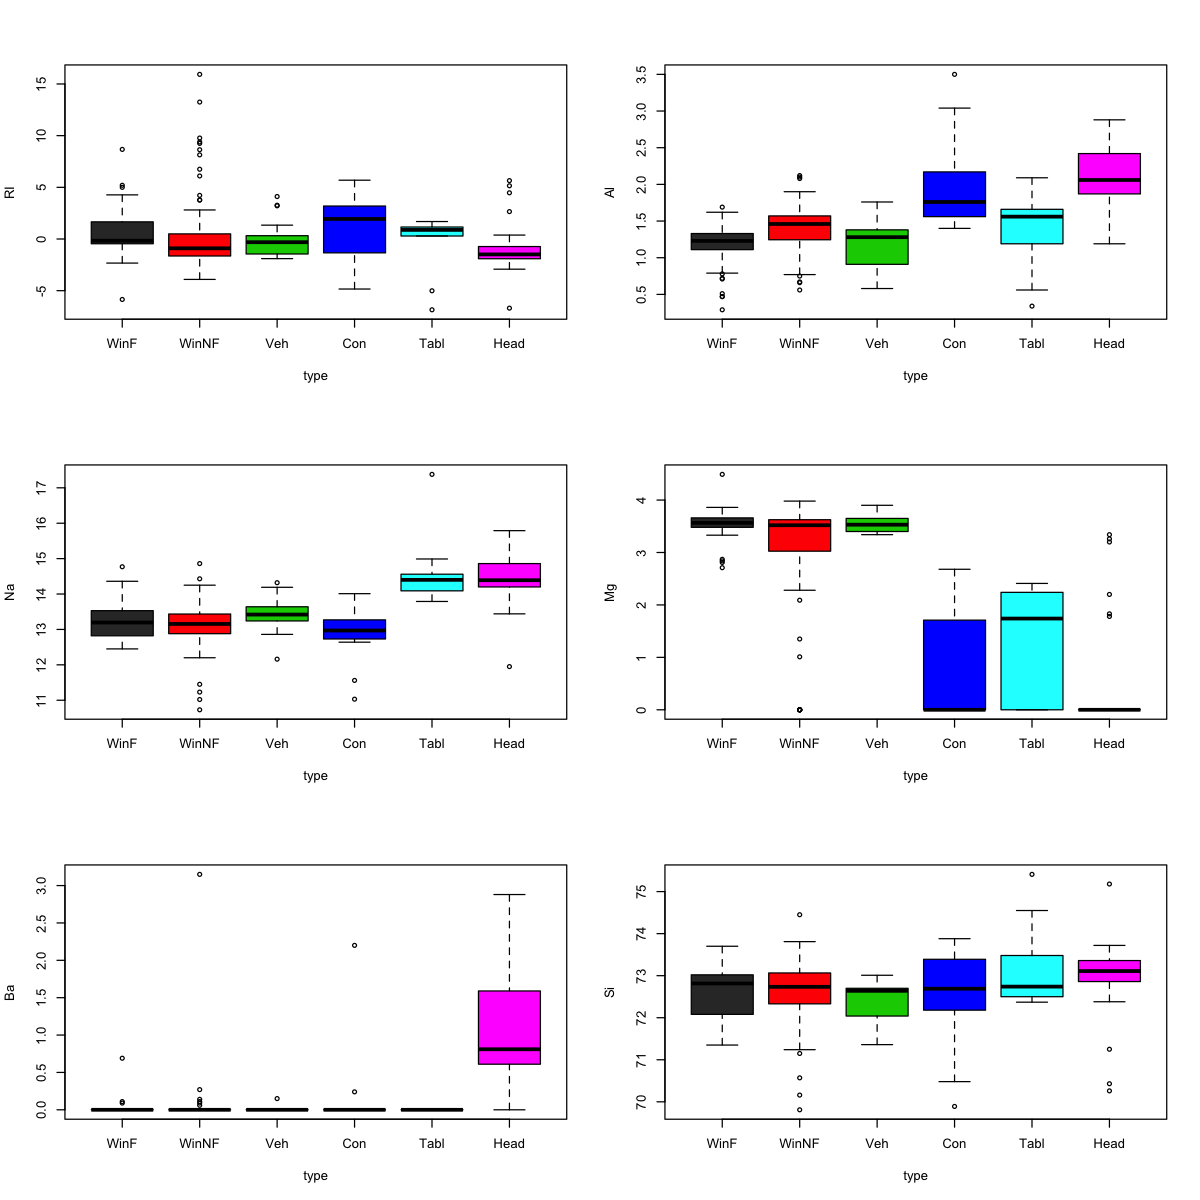

In [5]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 10)

#Plot a few of the variables (note: the nature of this type of plot will default to boxplot)
par(mfrow=c(3,2))
plot(RI ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Al ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Na ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Mg ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Ba ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Si ~ type, data=fgl, col=c(grey(.2),2:6))

### Perform K-NN

In [6]:
##Scale data so that distances are in standard deviations
# make numerica and scale
# convert columns to mean-zero sd-one
# column 10 is the class label so want to scale the first 9 columns
x <- scale(fgl[,1:9]) 

##View the scaling has been performed with the apply function
apply(x, #what data to apply a function to (in this case the matrix x)
      2, #since we are dealing with a matrix, apply function to columns (note 1 means rows and 2 means columns)
      sd #function we are applying to columns (take standard deviation of each column)
     ) # see ?apply

#NOTE: each column should have standard deviation of 1 for x

RI Na Mg Al Si  K Ca Ba Fe 
 1  1  1  1  1  1  1  1  1

In [7]:
### NOTE: There is no need to train a K-NN so we will test model on 10 of the available data points

## Use 200 training points to find nearest neighbors for 14

#Load class library to get K-NN classifier
library(class)

#Sample 10 indicies to use as the test observations
test <- sample(1:214,10)

#Run a K-NN using 1 nearest neighbor to classify item
nearest1 <- knn(train=x[-test,], test=x[test,], cl=fgl$type[-test], k=1)

#Run a K-NN using 5 nearest neighbors to classify item
nearest5 <- knn(train=x[-test,], test=x[test,], cl=fgl$type[-test], k=5)

##View results of each classifier
data.frame(fgl$type[test],nearest1,nearest5)

fgl.type.test. nearest1 nearest5
1  WinNF          WinNF    WinF    
2  WinNF          WinNF    WinNF   
3  Head           WinNF    WinF    
4  WinNF          WinNF    WinNF   
5  WinF           WinF     WinF    
6  WinNF          WinNF    Con     
7  WinNF          WinNF    WinNF   
8  WinF           WinNF    WinNF   
9  WinF           WinF     WinF    
10 WinNF          Veh      WinNF

## Probability, Cost, and Classification

To better understand the relationship netween probabilities and classification, we will look to examine a credit scoring example using a German Credit dataset.

In [8]:
## read data
credit <- read.csv("credit.csv")

In [9]:
### Create some interesting variables

## re-level the credit history and checking account status
credit$history = factor(credit$history, levels=c("A30","A31","A32","A33","A34"))
levels(credit$history) = c("good","good","poor","poor","terrible")

## a few others
credit$foreign <- factor(credit$foreign, levels=c("A201","A202"), labels=c("foreign","german"))
credit$rent <- factor(credit$housing=="A151")
credit$purpose <- factor(credit$purpose, levels=c("A40","A41","A42","A43","A44","A45","A46","A47","A48","A49","A410"))
levels(credit$purpose) <- c("newcar","usedcar",rep("goods/repair",4),"edu",NA,"edu","biz","biz")

In [10]:
#Specify dataset as the following
credit <- credit[,c("Default", "duration", "amount",
                    "installment", "age", "history",
                    "purpose", "foreign", "rent")]

In [11]:
#View structure of updated dataset
str(credit)

'data.frame':	1000 obs. of  9 variables:
 $ Default    : int  0 1 0 0 1 0 0 0 0 1 ...
 $ duration   : int  6 48 12 42 24 36 24 36 12 30 ...
 $ amount     : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ installment: int  4 2 2 2 3 2 3 2 2 4 ...
 $ age        : int  67 22 49 45 53 35 53 35 61 28 ...
 $ history    : Factor w/ 3 levels "good","poor",..: 3 2 3 2 2 2 2 2 2 3 ...
 $ purpose    : Factor w/ 5 levels "newcar","usedcar",..: 3 3 4 3 1 4 3 2 3 1 ...
 $ foreign    : Factor w/ 2 levels "foreign","german": 1 1 1 1 1 1 1 1 1 1 ...
 $ rent       : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 1 2 1 1 ...


### Treating the response variable as default, we will look to run a logistic lasso regression to predict default with all predictors interacted with one another.

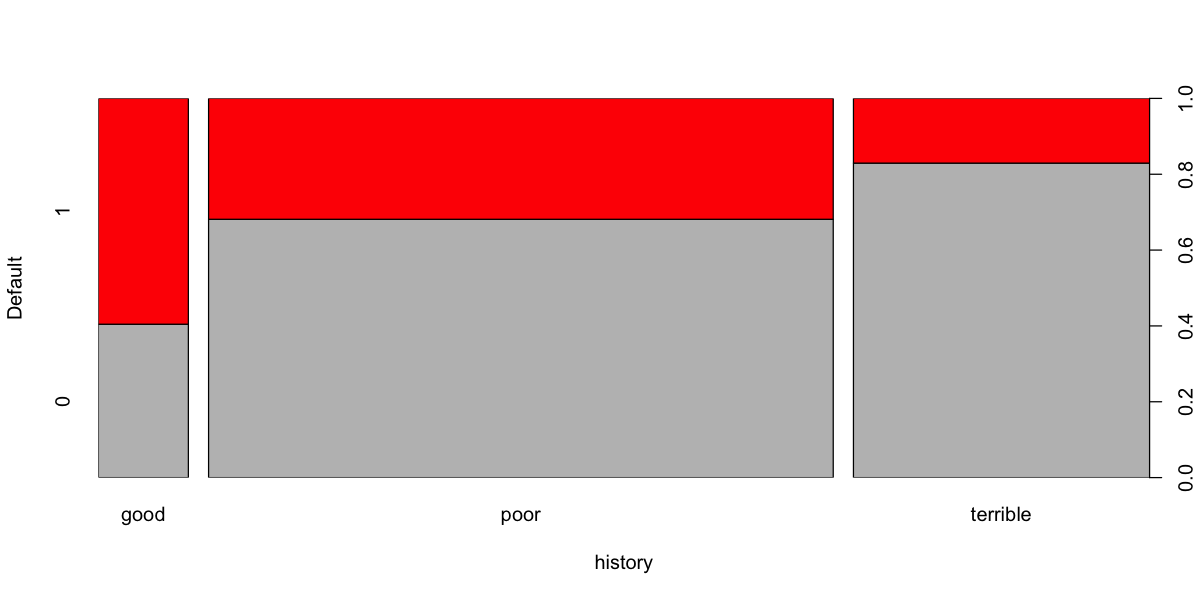

In [13]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

## plot a mosaic to view the default variable
plot(factor(Default) ~ history, data=credit, col=c(8,2), ylab="Default") ## surprise!

In [14]:
#Use the glmnet library (note: gamlr was not compatible with anaconda)
library("glmnet")

#Use Matrix package to create sparse model matrix
library("Matrix")

#Load functions from naref.R script to help factor columns
source("naref_no_gamlr.R")

#note: the function utlized from the r-script file is the naref function (stands for NA reference level)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [15]:
#Build a design matrix 
credx <- sparse.model.matrix( Default ~ .^2, data=naref(credit))[,-1]

#Pull out response variable
default <- credit$Default

In [22]:
#Perform lasso regression with 5 fold cross validation
credscore <- cv.glmnet(credx, default, family="binomial", nfolds=5,lambda.min.ratio=0.01)

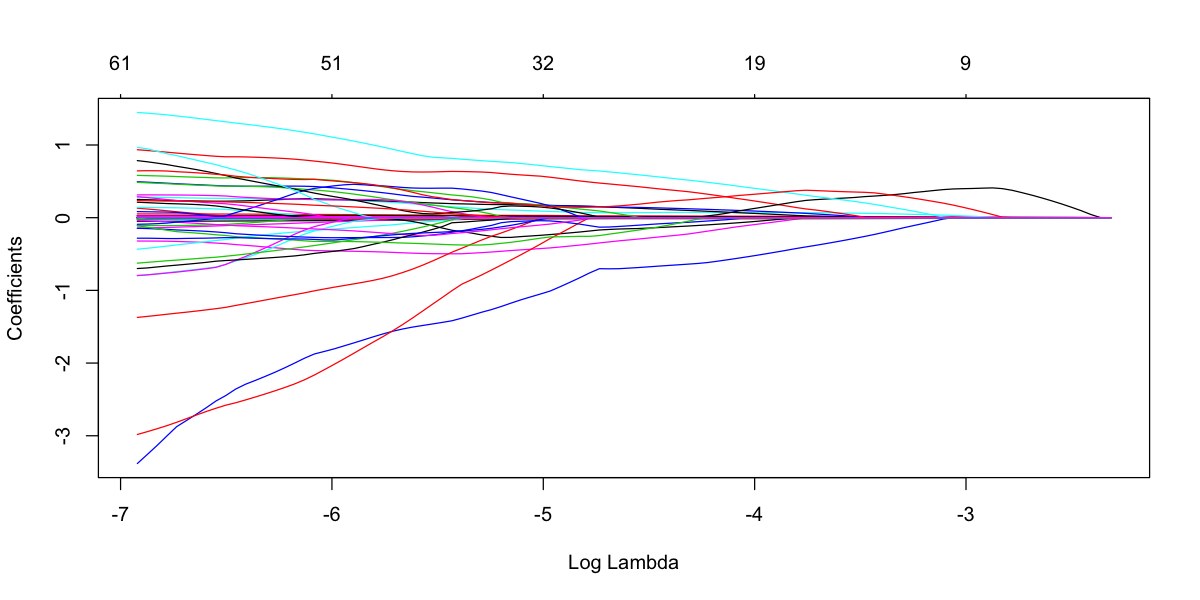

In [23]:
### View coefficient path plot
plot(credscore$glmnet.fit, xvar="lambda")

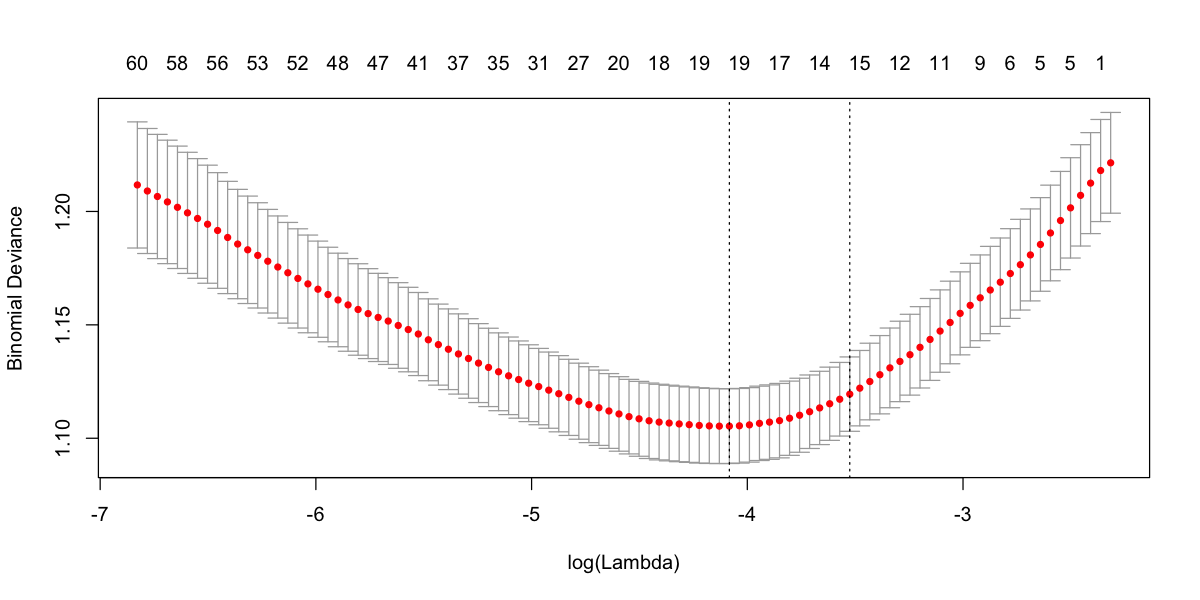

In [24]:
#View plot of range of coefficient values from cross validation
plot(credscore)

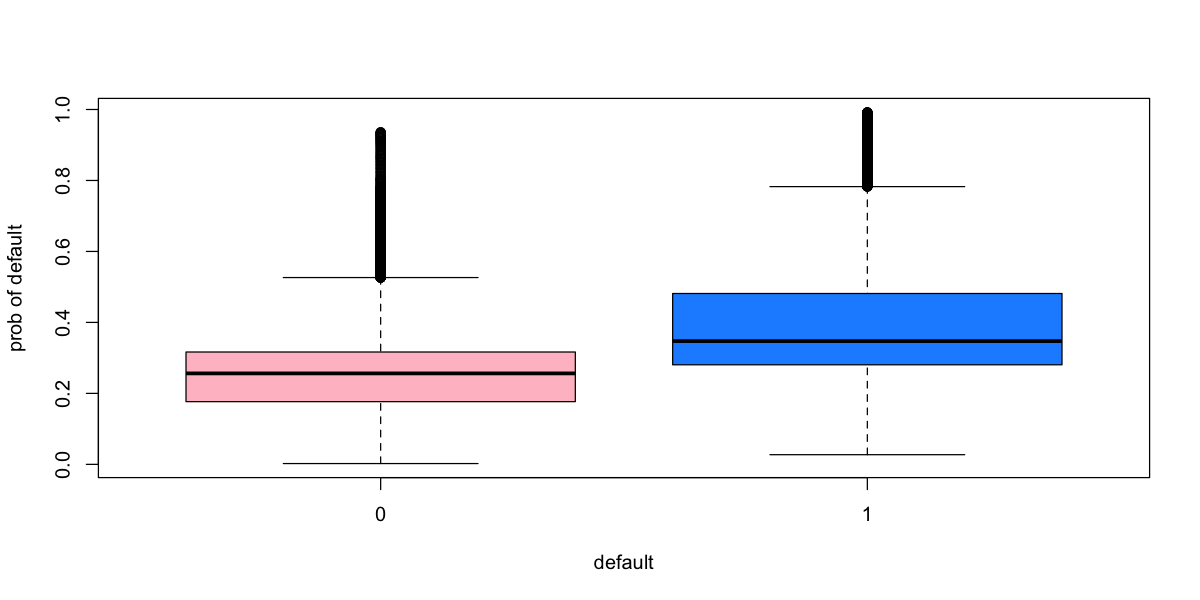

In [25]:
#Obtain probabilities of default
pred <- predict(credscore$glmnet.fit, credx, type="response")

#Remove the sparse Matrix formatting
pred <- drop(pred) 

#Plot the predictions
boxplot(pred ~ default, xlab="default", ylab="prob of default", col=c("pink","dodgerblue"))

In [26]:
## what are our misclassification rates?

#Assume the the threshold level for classifying a predicted probability as default is set as follows
# note: this can be adjusted which will affect the misclassififcation rates
rule <- 1/5

#for presentation, make as a list
list(

## false positive rate
"fpr" = sum( (pred>rule)[default==0] )/sum(pred>rule),

## false negative rate
"fnr" = sum( (pred<rule)[default==1] )/sum(pred<rule),

## sensitivity
"sensitivity" = sum( (pred>rule)[default==1] )/sum(default==1),

## specificity
"specificity" = sum( (pred<rule)[default==0] )/sum(default==0) )


### Try with different threshold
rule <- 0.5

#for presentation, make as a list
list(

## false positive rate
"fpr" = sum( (pred>rule)[default==0] )/sum(pred>rule),

## false negative rate
"fnr" = sum( (pred<rule)[default==1] )/sum(pred<rule),

## sensitivity
"sensitivity" = sum( (pred>rule)[default==1] )/sum(default==1),

## specificity
"specificity" = sum( (pred<rule)[default==0] )/sum(default==0) )

$fpr
[1] 0.6313269

$fnr
[1] 0.08009413

$sensitivity
[1] 93.64667

$specificity
[1] 31.27286

$fpr
[1] 0.3103413

$fnr
[1] 0.2580091

$sensitivity
[1] 22.36333

$specificity
[1] 95.68714

### Let's Construct an Reciever Operator Curve (ROC) to visualize the specificity and sensitivity of our model at different thresholds. Ww will create an ROC for in-sample and out-of-sample predictions.

In [27]:
## refit the model using only 1/2 of data

#Sample indicies to get observations to use as test data
test <- sample.int(1000,500)

#Fit model on half of the data
credhalf <- glmnet(credx[-test,], default[-test], family="binomial")

#Generate predictions
predoos <- predict(credhalf, credx[test,], type="response")

#Gather the actual default status for test data
defaultoos <- default[test]

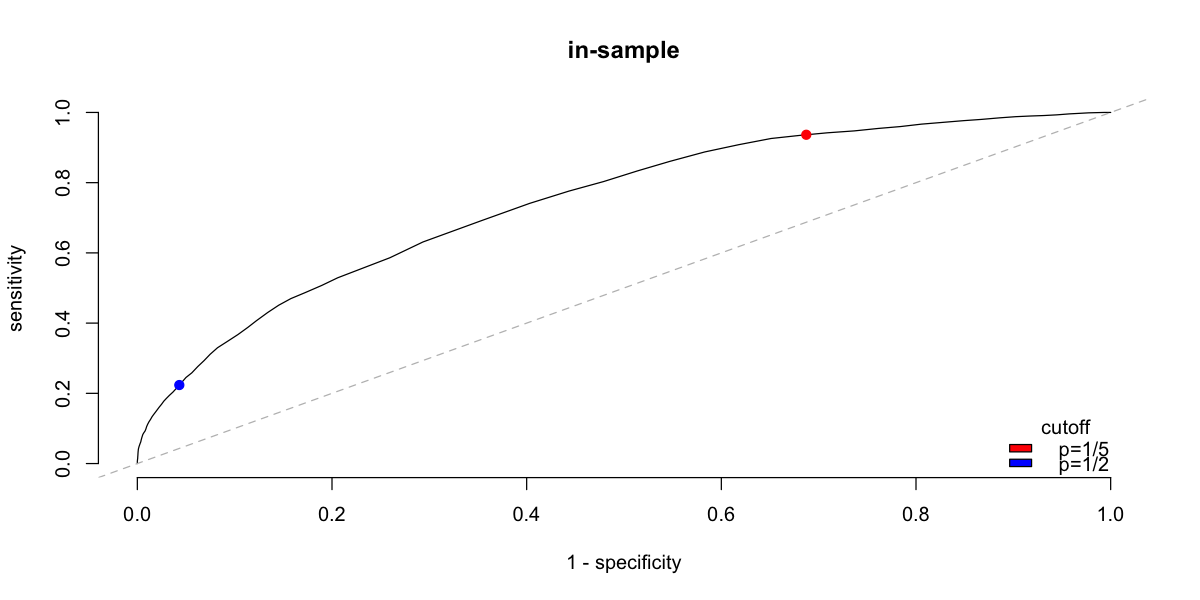

In [28]:
##Plot ROC for in-sample

#Load ROC script
source("roc.R")

#Construct ROC plot
roc(p=pred, y=default, bty="n", main="in-sample")

## Highlight our 1/5 threshold
points(x= 1-mean((pred<.2)[default==0]), 
    y=mean((pred>.2)[default==1]), 
    cex=1.5, pch=20, col='red')

## a standard `max prob' (p=.5) rule
points(x= 1-mean((pred<.5)[default==0]), 
    y=mean((pred>.5)[default==1]), 
    cex=1.5, pch=20, col='blue') 
legend("bottomright",fill=c("red","blue"),
    legend=c("p=1/5","p=1/2"),bty="n",title="cutoff")

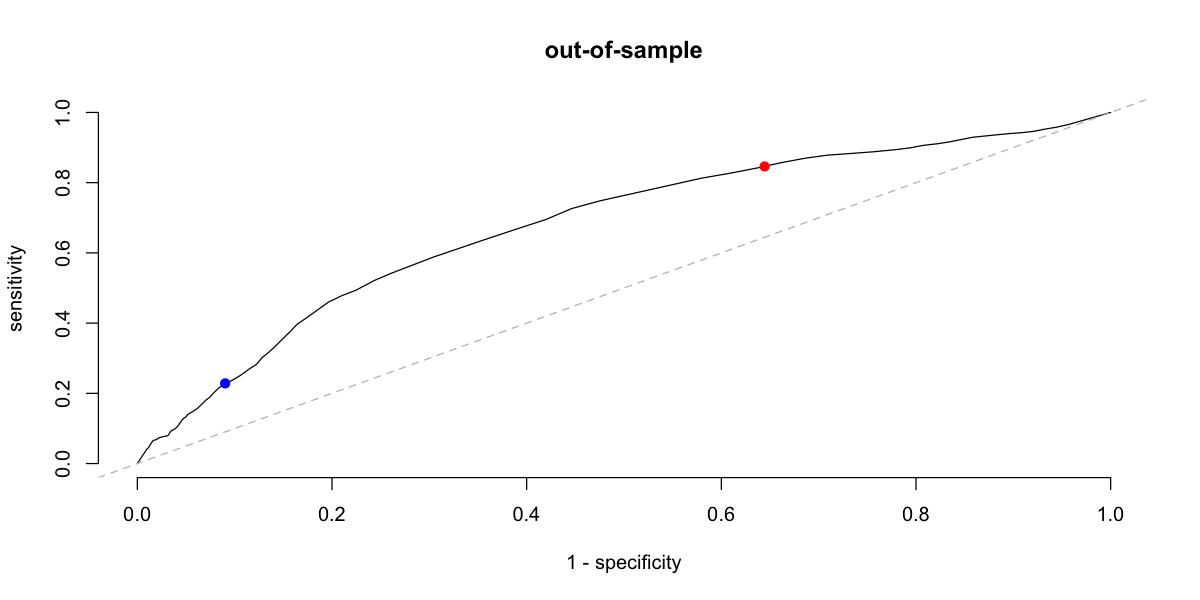

In [29]:
## Plot ROC for out-sample test data

#Construct ROC plot
roc(p=predoos, y=defaultoos, bty="n", main="out-of-sample")

## Highlight 1/5 rule cutoff
points(x= 1-mean((predoos<.2)[defaultoos==0]), 
    y=mean((predoos>.2)[defaultoos==1]), 
    cex=1.5, pch=20, col='red') 

## Highlight a standard `max prob' (p=.5) rule
points(x= 1-mean((predoos<.5)[defaultoos==0]), 
    y=mean((predoos>.5)[defaultoos==1]), 
    cex=1.5, pch=20, col='blue') 

## Multinomial Logistic Regression

Multinomial logistic regression works to fit a regression to a categorical variable using the logit link function. We will return to the fgl dataset, describing the different types of glass, for our discussion of multinomial logistic regression.

In [30]:
## we'll consider all of the content variables, interacted with RI
## You could also look at all interactions; you get diff model but similar performance OOS
xfgl <- sparse.model.matrix(type~.*RI, data=fgl)[,-1]

#Pull out respinse variable: glass type
gtype <- fgl$type

Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”

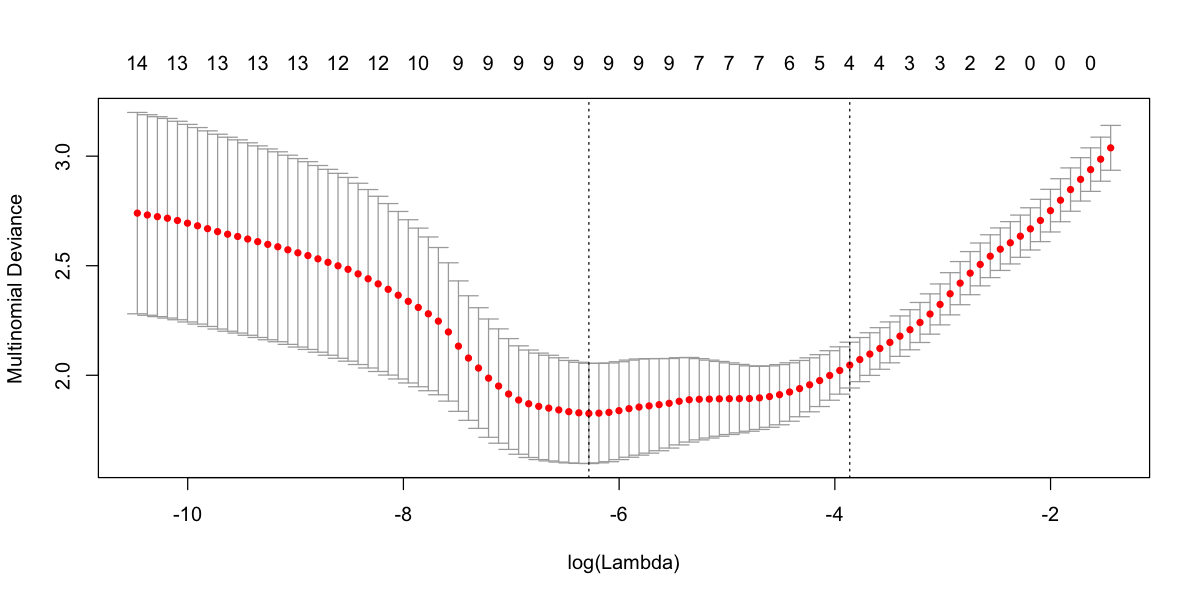

In [31]:
#Fit the multinomial logistic regression with lasso regularization
glassfit <- cv.glmnet(xfgl, gtype, family="multinomial")

#CV error; across top avg # nonzero across classes
plot(glassfit)

#note: disregard warning

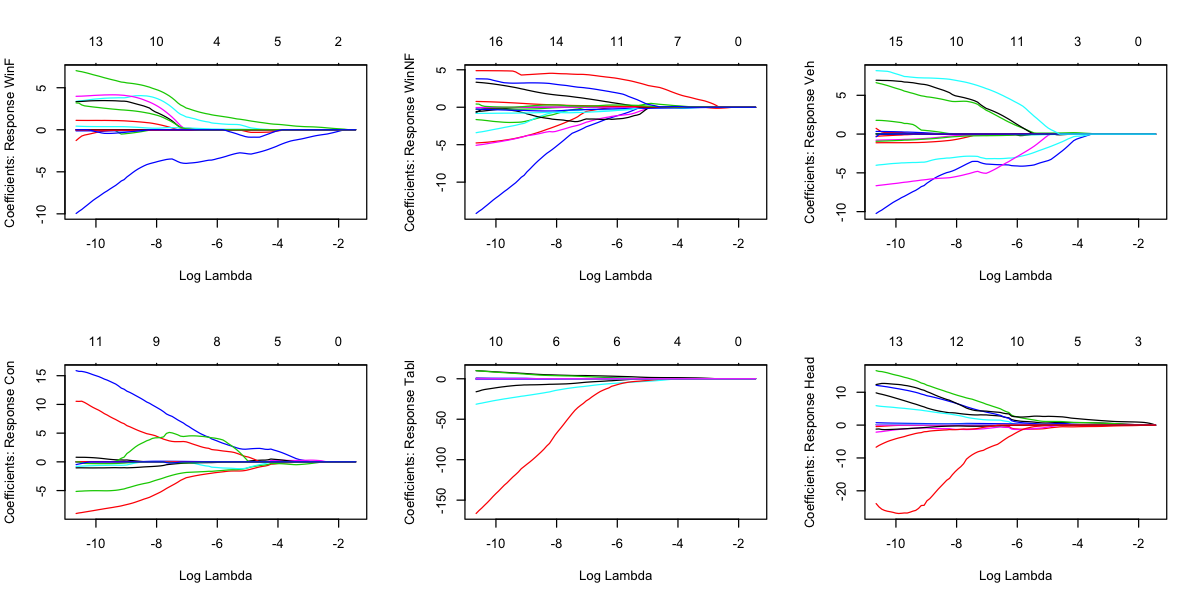

In [33]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

## plot the 6 sets of coefficient paths for each response class
par(mfrow=c(2,3)) ## note we can use xvar="lambda" to plot against log lambda
plot(glassfit$glmnet.fit, xvar="lambda") 

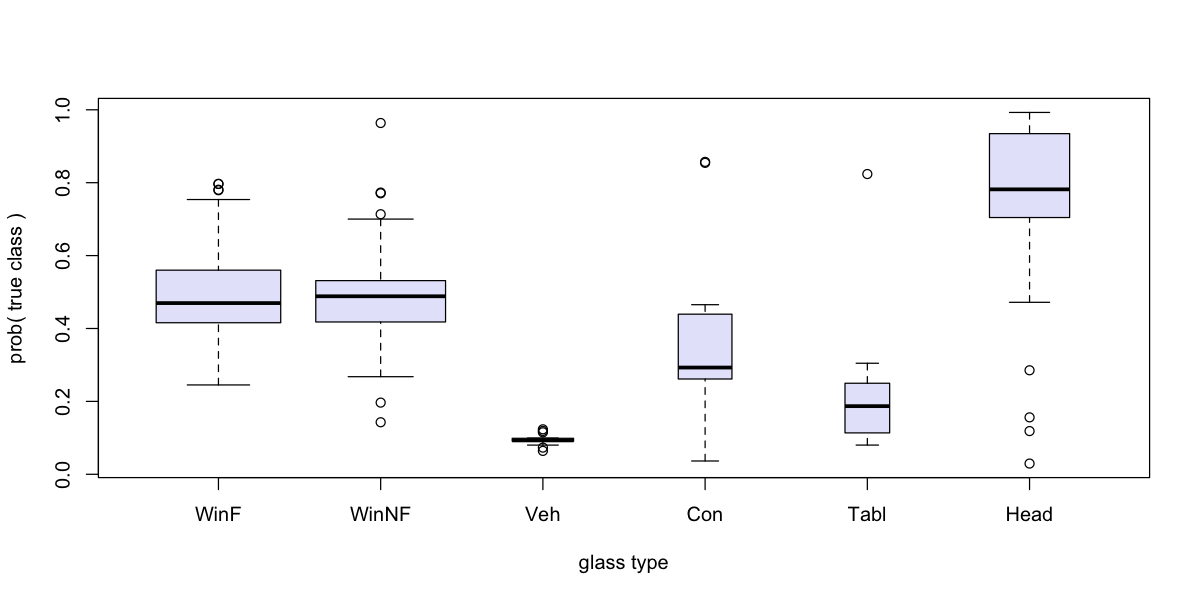

In [34]:
### fit plots: plot p_yi distribution for each true yi

# use predict to get in-sample probabilities
probfgl <- predict(glassfit, xfgl, type="response")

# for some reason glmnet gives back predictions as an nxKx1 array. 
# use drop() to make it an nxK matrix
probfgl <- drop(probfgl)

# get the probs for what actually happened
# note use of a matrix to index a matrix! 
# gives back the [i,j] entry of probfgl for each row of index matrix 
# so, here, that's the probability of true class for each observation
n <- nrow(xfgl)
trueclassprobs <- probfgl[cbind(1:n, gtype)] 

## plot true probs, with varwidth to have the box widths proportional to response proportion.
plot(trueclassprobs ~ gtype, col="lavender", varwidth=TRUE,
    xlab="glass type", ylab="prob( true class )") 

In [35]:
## To extract regression coefficients
B  <- coef(glassfit, select="min")

# it's a list of coefficients, 1 matrix per glass type.
B 

## combine into a matrix
B <- do.call(cBind, B)

## annoyingly, column names are dropped and to add them back
colnames(B) <- levels(gtype)

$WinF
18 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  3.96298955
RI           .         
Na          -0.05863666
Mg           0.60200210
Al          -1.68115106
Si           .         
K            .         
Ca           .         
Ba           .         
Fe           .         
RI:Na        .         
RI:Mg        .         
RI:Al        .         
RI:Si        .         
RI:K         .         
RI:Ca        .         
RI:Ba        .         
RI:Fe        .         

$WinNF
18 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) 13.57777438
RI           .         
Na           .         
Mg           0.14670616
Al           .         
Si          -0.15377641
K            .         
Ca           .         
Ba           .         
Fe           1.56743202
RI:Na        .         
RI:Mg       -0.07707164
RI:Al        .         
RI:Si        .         
RI:K         .         
RI:Ca        0.01361346
RI:Ba        0.03200987
RI:Fe        0

Warning message:
“'cBind' is deprecated.
 Since R version 3.2.0, base's cbind() should work fine with S4 objects”

In [36]:
## For an extra 1 unit of Mg at RI=0:

RI <- 0

# @RI=0 odds of non-float over float drop by  30-40% 
exp( (B["Mg","WinNF"]+RI*B["RI:Mg","WinNF"]) -
            (B["Mg","WinF"]+RI*B["RI:Mg","WinF"]) )  

# but odds of non-float over Con increase by 60-70% 
exp( (B["Mg","WinNF"]+RI*B["RI:Mg","WinNF"]) -
            (B["Mg","Con"]+RI*B["RI:Mg","Con"]) )  

[1] 0.6342602

[1] 1.611937

[1] 11

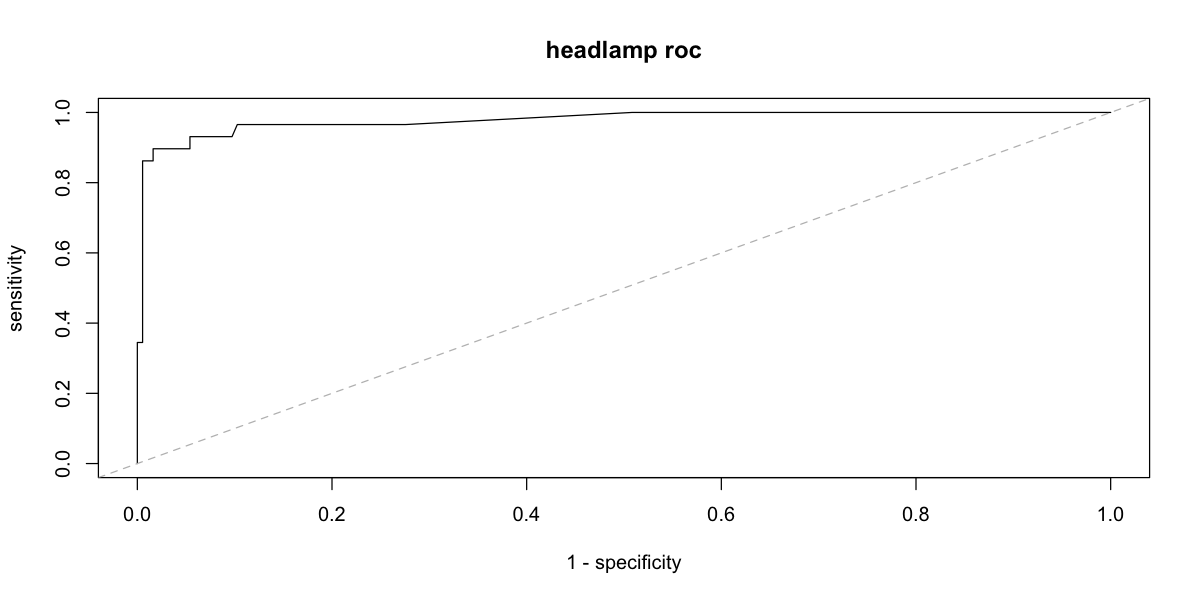

In [37]:
## Classification: Look to plot a ROC curve for either glass type head or not head

## looking at Head vs all others (using 0.9 rule from slides)
headclass <- probfgl[,'Head'] > .9
sum(headclass)
## you can also employ all of the binary classification idea
## whenever you are making one-vs-all-others type comparisons
## e.g., ROC plot for headlamp glass vs other glass classification
source("roc.R")
roc(p=probfgl[,'Head'], y=gtype=="Head", main="headlamp roc")

## Distributed Multinomial Regression (DMR)

We can use a poisson approximation scheme to calculate the parameters of our multinomial logistic regression. Thus, we can speed up the process of fitting a multinomial logistic reression since the coefficients in parallel.

### Look to the classification_glmnet_and_dmr.R script for dmr code since distrom package utilizes gamlr which is not compatible with anaconda